In [1]:
##CS 301 Project
##Priyanka Racharla
##Fake News Detection in English and Spanish

In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import simplemma
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Pre-Processing
#Configuring datasets to be easily processed later

In [4]:
#English Fake News Dataset 
en_train_data = pd.read_csv('English_Dataset_Fake News.csv')
en_train_data = en_train_data.loc[:, ['title','text', 'label']]
#Rename columns
en_train_data.columns = ['Title','Text', 'Category']
#Map Category values to Fake and Real only 
en_train_data['Category'] = en_train_data['Category'].map({'FAKE': 'Fake', 'REAL': 'Real'})
#Drop rows where text and category are empty strings...there were non Nan values
for i in range(0, len(en_train_data)):
    if (en_train_data['Text'][i].isspace()): 
        en_train_data['Text'][i] = np.nan
    if (en_train_data['Category'][i].isspace()): 
        en_train_data['Category'][i] = np.nan      
en_train_data = en_train_data.dropna()

#Export and read in training portion of dataset
en_train = en_train_data.iloc[:5039]
en_train.to_csv('English_Train.csv',  index=False)
en_train = pd.read_csv('English_Train.csv')
en_train.head()

#Export and read in testing portion of dataset
en_test = en_train_data.iloc[5039:]
en_test.to_csv('English_Test.csv',  index=False)
en_test = pd.read_csv('English_Test.csv')
en_test.head()

,Title,Text,Category
0,Russell Brand’s Back on ‘The Trews’ and He’s G...,$23 Russell Brand’s Back on ‘The Trews’ and He...,Fake
1,UFO over the East Valley here in AZ last night.,UFO over the East Valley here in AZ last night...,Fake
2,Putin: Russia Is Not Going To Attack Anyone,Complaining about Western “hysteria” surroundi...,Fake
3,How to Tell Debt Facts From Political Hype,"Recent remarks by Donald Trump, the presumptiv...",Real
4,Trump on Twitter: Hillary is 'Brainwashed',Donald Trump took to Twitter Saturday morning ...,Real


In [5]:
#SPANISH Fake News Dataset 
spn_train_data = pd.read_excel('Spanish_Dataset_Fake News.xlsx') 
spn_train_data =spn_train_data.loc[:, ['Headline', 'Text', 'Category']]
#Rename columns
spn_train_data.columns = ['Title','Text', 'Category']
#Map Category values to Fake and Real only 
spn_train_data['Category'] = spn_train_data['Category'].map({'Fake': 'Fake', 'True': 'Real'})
spn_train_data

#Export and read in training portion of dataset
spn_train = spn_train_data.iloc[:541]
spn_train.to_csv('Spanish_Train.csv',  index=False)
spn_train = pd.read_csv('Spanish_Train.csv')
spn_train.head()

#Export and read in testing portion of dataset
spn_test = spn_train_data.iloc[541:]
spn_test.to_csv('Spanish_Test.csv',  index=False)
spn_test = pd.read_csv('Spanish_Test.csv')
spn_test.head()

,Title,Text,Category
0,EEUU: Lista la Flota del Pacífico para interve...,EEUU: Lista la Flota del Pacífico para interve...,Fake
1,La Cámara de Diputados aprueba una ley para de...,La Cámara de Diputados aprueba una ley para de...,Fake
2,FARC felicita a AMLO y le pide apoyar la paz e...,FARC felicita a AMLO y le pide apoyar la paz e...,Real
3,"Calderón acusa ""silencio cómplice"" de AMLO por...","Calderón acusa ""silencio cómplice"" de AMLO por...",Real
4,"""Me vale madre, Tromp o nos respetas o entrare...","""Me vale madre, Tromp o nos\nrespetas o entrar...",Fake


In [6]:
#Translated Testing Datasets
enTran_spanTest = pd.read_csv("EN_Tran_Spanish_Test.csv")  #Spanish Test dataset translated into ENGLISH
spnTran_enTest = pd.read_csv("Spn_Tran_English_Test.csv")  #English Test dataset translated into SPANISH
enTran_spanTest.head()
spnTran_enTest.head()

,Title,Text,Category
0,Russell Brand’s Back on ‘The Trews’ and He’s G...,"$ 23 Russell Brand en ""The Trews"" y tiene bast...",Fake
1,UFO over the East Valley here in AZ last night.,Ovni por el valle este aquí en AZ anoche. Pági...,Fake
2,Putin: Russia Is Not Going To Attack Anyone,"Quejándose de la ""histeria"" occidental en torn...",Fake
3,How to Tell Debt Facts From Political Hype,"Observaciones recientes de Donald Trump, el pr...",Real
4,Trump on Twitter: Hillary is 'Brainwashed',Donald Trump acudió a Twitter el sábado por la...,Real


In [7]:
#Processing with help of NLTK for English Based Datasets
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('words') #download list of english words
nltk.download('stopwords') #download list of stopwords

lemmatizer = WordNetLemmatizer()
stopWords = stopwords.words('english')
enWords = set(nltk.corpus.words.words()) 

#Adjust text to be lowercased and remove any weird characters 
def lower_char_process(text): 
    #Lowercase text
    text = text.lower() 
    #Remove URLS 
    text = re.sub('https://.*\s?', '', text)
    #Remove any weird characters, contractions
    text = re.sub('[^a-zA-Z0-9 \n\.]', '', text)
    text = text.replace('.', '')
    return text 

#map nltk part of speech tags to tags recognized by wordnet
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
#Lemmatize tokens made from text
def lemmatized(tokens): 
    nltk_tagged = nltk.pos_tag(tokens)
    lemmas = [] 
    for word, tag in nltk_tagged: 
        tag = nltk_pos_tagger(tag)
        if tag is None:
            lemmas.append(word)
        else: 
            lemmas.append(lemmatizer.lemmatize(word,tag))
    return lemmas

#Remove stop words 
def stopWordRemoval(tokens): 
    stopWordRemoved = []
    for token in tokens: 
        if token in enWords and token not in stopWords: 
            stopWordRemoved.append(token)
    return stopWordRemoved

def process(df) : 
    textCol = []
    for i in range(0, len(df)):
        text = df['Text'][i]
        #Adjust text to be lowercased and remove any weird characters
        text = lower_char_process(text)
        #Tokenization of data 
        tokenizer = RegexpTokenizer(r'\w+')
        text = tokenizer.tokenize(text)
        #Lemmatization of tokens
        text = lemmatized(text)
        #Remove stop words 
        text = stopWordRemoval(text)
        # Joining the processed text as a WHOLE string again
        text = ' '.join(text)
        #print(str(i) + "\n" + str(text))
        
        textCol.append(text)
    return textCol

[nltk_data] Downloading package words to C:\Users\P
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\P
[nltk_data]     R\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#Spanish Processing w/ NLTK and Simplemma
#NLTK does not provide spanish support for lemmatization...so had to use Simplemma
simpLang = simplemma.load_data('es')
stopWord_spn = stopwords.words('spanish')

def spn_lower_char_process(text): 
    #Lowercase text
    text = text.lower() 
    #Remove URLS 
    text = re.sub('https://.*\s?', '', text)
    text = text.replace('*NUMBER*', '')
    #Remove any weird characters, contractions
    text = re.sub('[^a-zA-Z0-9 \n\.ÁáéÉíÍñÑÓóÚÜúü]', '', text)
    text = text.replace('.', '')
    return text 

def spanLemmatize(text): 
    text = [simplemma.lemmatize(token, simpLang) for token in text]
    return text

def stopWordSpn(tokens): 
    stopWordRemoved = []
    for token in tokens: 
        #Remove newline characters and 'adj'/'f'
        removeChar = ['\n', 'adj', 'f']
        if token not in stopWord_spn and token not in removeChar: 
            stopWordRemoved.append(token)
    return stopWordRemoved    

def spanProcess(df) : 
    textCol = []
    for i in range(0, len(df)):
        text = df['Text'][i]
        #Adjust text to be lowercased and remove any weird characters
        text = spn_lower_char_process(text)
        #Tokenize
        tokenizer = RegexpTokenizer(r'\w+')
        text = tokenizer.tokenize(text)
        #Remove stop words in spanish
        text = stopWordSpn(text)
        #lemmatize....in spanish, verb+definite article can be used as one word so lemmatization breaks them up into root
        text = spanLemmatize(text)
        # Joining the processed text as a WHOLE string again
        text = ' '.join(text)
        #print(str(i) + "\n" + str(text))
        textCol.append(text)
    return textCol

In [9]:
#Store processed text in a file for easier accessing
def processStore(textProc, filename): 
    textProc1 = pd.Series(textProc, name = 'Text')
    textProc1.to_csv(filename,  index=False)
    
#Get processed text from file 
def getText(filename):
    textProc2 = pd.read_csv(filename)
    #CountVectorize() does not like nan values using fit_transform()...so convert nan to empty string
    textProc2 = textProc2.replace(np.nan,'',regex=True)
    textProcList = list(textProc2['Text'])
    return textProcList

In [10]:
#Processing and storing English Training Dataset
enTrain_TextProc = process(en_train)
processStore(enTrain_TextProc, 'Processed/Processed_EN_Train.csv')

#Processing and storing English TESTING Dataset
enTest_TextProc = process(en_test)
processStore(enTest_TextProc, 'Processed/Processed_EN_TEST.csv')

In [11]:
#Processing and storing Spanish Training Dataset
spnTrain_TextProc = spanProcess(spn_train)
processStore(spnTrain_TextProc, 'Processed/Processed_Spn_Train.csv')

#Processing and storing Spanish TESTING Dataset
spnTest_TextProc = spanProcess(spn_test)
processStore(spnTest_TextProc, 'Processed/Processed_Spn_TEST.csv')

In [12]:
#Processing and storing TRANSLATED Spanish to English Dataset
enSpanTest_textProc = process(enTran_spanTest)
processStore(enSpanTest_textProc, 'Processed/Processed_EngTran_Spanish_Test.csv')

In [13]:
#Processing and storing TRANSLATED English to Spanish Dataset
spnEnTest_textProc = spanProcess(spnTran_enTest)
processStore(spnEnTest_textProc, 'Processed/Processed_SpnTran_English_Test.csv')

In [14]:
#Feature Extraction - Vectorize strings into numbers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

count_vectorizer = CountVectorizer()
le = LabelEncoder()

def vectorizeTrainData(textList, df):    
    x = count_vectorizer.fit_transform(textList).toarray()
    #Convert Category label into numbers (0,1) for Fake and Real respectively
    y = df.iloc[:,-1].values
    y = le.fit_transform(y)
    return [x, y]

def vectorizeTestData(textList, df):     
    x = count_vectorizer.transform(textList).toarray()
    #Convert Category label into numbers (0,1) for Fake and Real respectively
    y = df.iloc[:,-1].values
    y = le.fit_transform(y)
    return [x, y]

#Import models 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Metrics to evaluate Model - Import
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Vectorize English Training and Testing Datasets
enTrain_TextList = getText('Processed/Processed_EN_Train.csv')
enTest_TextList = getText('Processed/Processed_EN_TEST.csv')
enTrainVect = vectorizeTrainData(enTrain_TextList, en_train)
enTestVect = vectorizeTestData(enTest_TextList, en_test)

#Vectorize Spanish Training and Testing Datasets
spnTrain_TextList = getText('Processed/Processed_Spn_Train.csv')
spnTest_TextList = getText('Processed/Processed_Spn_Test.csv')
spnTrainVect = vectorizeTrainData(spnTrain_TextList,spn_train)
spnTestVect = vectorizeTestData(spnTest_TextList, spn_test)

#Vectorize Translated Test Datasets
enSpn_TextList = getText('Processed/Processed_EngTran_Spanish_Test.csv')  #English ver of Spanish Test Dataset
spnEn_TextList = getText('Processed/Processed_SpnTran_English_Test.csv')  #Spanish ver of English Test Dataset

enTrainVect = vectorizeTrainData(enTrain_TextList, en_train)
enSpn_TestVect = vectorizeTestData(enSpn_TextList, enTran_spanTest)

spnTrainVect = vectorizeTrainData(spnTrain_TextList,spn_train)
spnEn_TestVect = vectorizeTestData(spnEn_TextList, spnTran_enTest)

#Train model and test it
def modeling(model, trainVect, testVect): 
    model.fit(trainVect[0], trainVect[1])
    y_pred = model.predict(testVect[0]) 
    #Calculate accuracy btwn predicted values by model and actual values from Dataset
    acc = accuracy_score(testVect[1], y_pred)
    #Calculate probability for positive outcome 
    y_pos = model.predict_proba(testVect[0])[:, 1]
    #Return necessary information (values in dict) needed for keys --> makes it easier to access 
    return {'model': model, 'confusionMatrix' : [testVect[1], y_pred], 'accuracy': acc, 'PrecisionRecall': [testVect[1], y_pos]}

#Function to pass correct vectorized data to model() and display accuracy and confusion matrix
def makeModel(model, language): 
    if language == 'en':
        trainVect = enTrainVect
        testVect = enTestVect
        lang = 'English'
    elif language == 'spn': 
        trainVect = spnTrainVect
        testVect = spnTestVect
        lang = 'Spanish'
    elif language == 'EnSpn':
        trainVect = enTrainVect
        testVect = enSpn_TestVect
        lang = 'English'
    elif language == 'SpnEn':
        trainVect = spnTrainVect
        testVect = spnEn_TestVect
        lang = 'Spanish'
    else: 
         raise ValueError("Invalid arguments")
       
    modelDict = modeling(model, trainVect, testVect)
    acc = modelDict['accuracy']
    print("Model trained in " + lang + " and using " + str(model) + " model has {:.2%} accuracy" .format(acc))
    
    #Make confusion matrix for model
    yVectTest = modelDict['confusionMatrix'][0]
    y_pred = modelDict['confusionMatrix'][1]
    cf_matrix = confusion_matrix(yVectTest, y_pred)
    #Labels for each quadrant & value
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='')
    title = "Confusion Matrix for " + str(model)  + "in " + lang + "\n\n"
    ax.set_title(title);
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    #Labels must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()
    
    return modelDict

from  matplotlib.ticker import PercentFormatter
#bar chart for accuracy 
def barChart(modelList, title): 
    labelList =[]
    valList = []
    
    for model in modelList:
        modelStr = str(model['model'])
        labelList.append(modelStr)
        accuracy =model['accuracy']*100
        valList.append(accuracy)
        
    dataDict = {'label' : labelList, 'value' : valList} 
    plt.figure(figsize=(5,5))
    ax = sns.barplot(x='label', y='value', data=dataDict)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.set_title(title, fontsize = 15)
    ax.set_xlabel('\nModels', fontsize = 15)
    ax.set_ylabel('Accuracy %', fontsize = 15)
    ax.yaxis.set_major_formatter(PercentFormatter())
    for c in ax.containers:
        ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)
    
from sklearn.metrics import precision_recall_curve
def precisionRecallChart(modelList, title):
    precisionList =[]
    recallList = []
    labelList =[]
    
    for model in modelList:
        modelStr = str(model['model'])
        y_test = model['PrecisionRecall'][0]
        y_score = model['PrecisionRecall'][1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_score)
         #Set up data for long format 
        for i in range(0, len(precision)):
            labelList.append(modelStr)
            precisionList.append(precision[i])
            recallList.append(recall[i])
        
    dataDf = pd.DataFrame((zip(labelList, recallList, precisionList)),columns =['Model', 'Recall', 'Precision'])
    ax = sns.lineplot(x="Recall", y="Precision", data = dataDf, hue="Model")
    ax.legend(loc='upper right', bbox_to_anchor=(1.7, 1))
    ax.set_title(title, fontsize = 15)

In [15]:
#Models used in this order: 
models = [GaussianNB(), LogisticRegression(max_iter=300), SGDClassifier(loss="modified_huber"), RandomForestClassifier(), DecisionTreeClassifier()]

Model trained in English and using GaussianNB() model has 67.06% accuracy


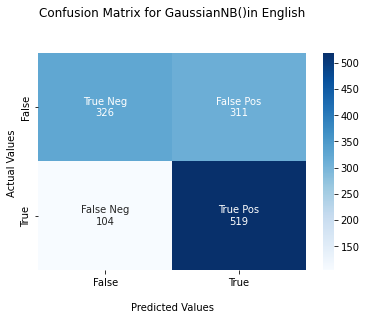

Model trained in English and using LogisticRegression(max_iter=300) model has 88.41% accuracy


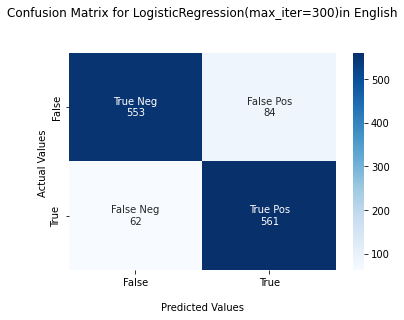

Model trained in English and using SGDClassifier(loss='modified_huber') model has 87.86% accuracy


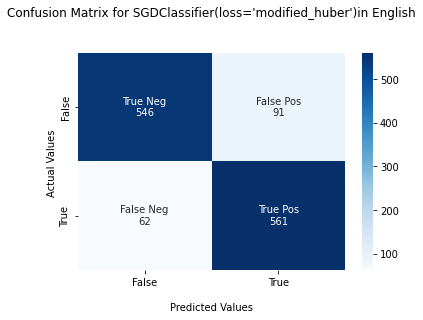

Model trained in English and using RandomForestClassifier() model has 86.98% accuracy


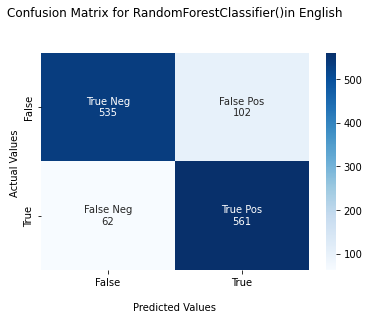

Model trained in English and using DecisionTreeClassifier() model has 78.89% accuracy


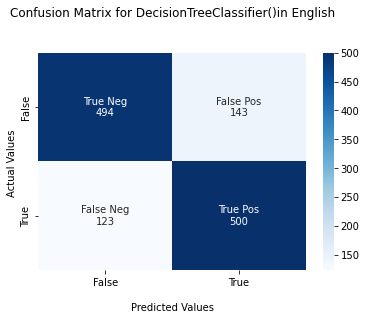

In [16]:
#English Models 
engModelList = []
for model in models: 
    enModel = makeModel(model, 'en')
    engModelList.append(enModel)

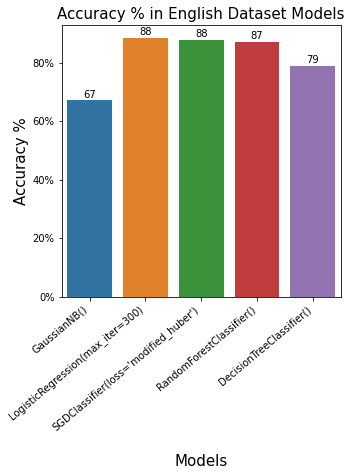

In [17]:
#Accuracy bar graph 
barChart(engModelList, 'Accuracy % in English Dataset Models')

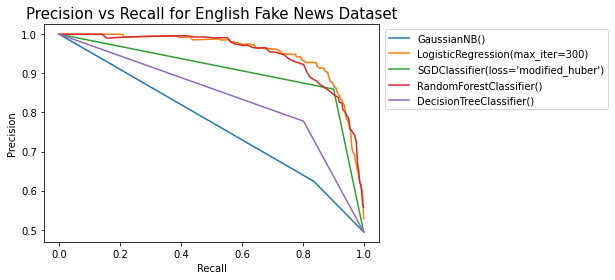

In [18]:
precisionRecallChart(engModelList, 'Precision vs Recall for English Fake News Dataset')

Model trained in Spanish and using GaussianNB() model has 60.74% accuracy


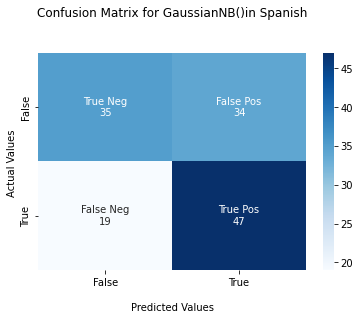

Model trained in Spanish and using LogisticRegression(max_iter=300) model has 78.52% accuracy


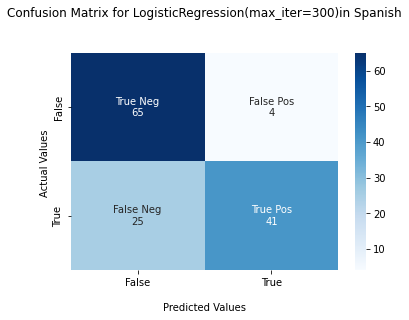

Model trained in Spanish and using SGDClassifier(loss='modified_huber') model has 74.81% accuracy


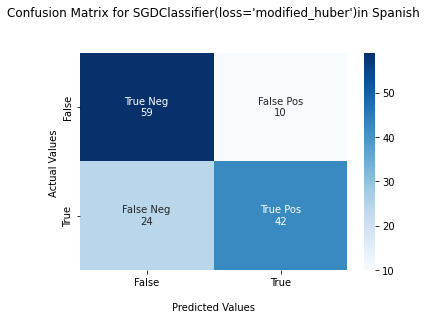

Model trained in Spanish and using RandomForestClassifier() model has 77.04% accuracy


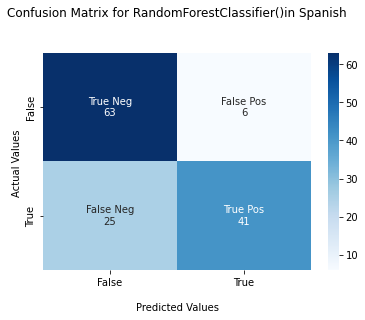

Model trained in Spanish and using DecisionTreeClassifier() model has 67.41% accuracy


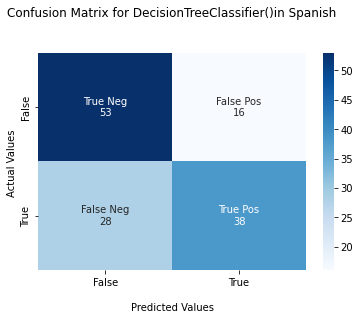

In [19]:
#Spaniish Models 
spnModelList = []
for model in models: 
    spnModel = makeModel(model, 'spn')
    spnModelList.append(spnModel)

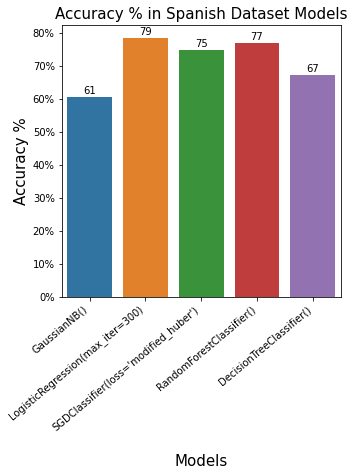

In [20]:
barChart(spnModelList, 'Accuracy % in Spanish Dataset Models')

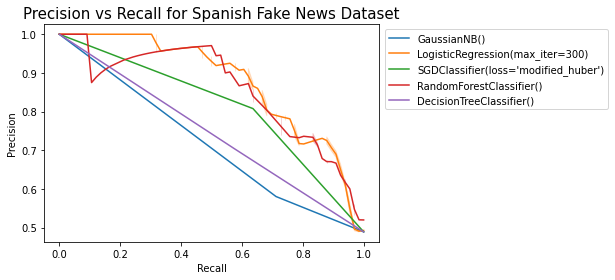

In [21]:
precisionRecallChart(spnModelList, 'Precision vs Recall for Spanish Fake News Dataset')

Model trained in English and using GaussianNB() model has 41.48% accuracy


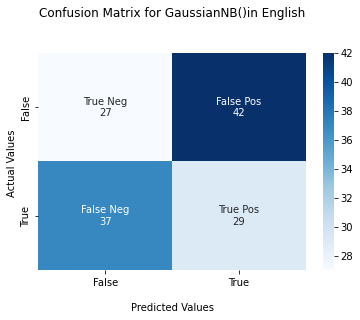

Model trained in English and using LogisticRegression(max_iter=300) model has 60.74% accuracy


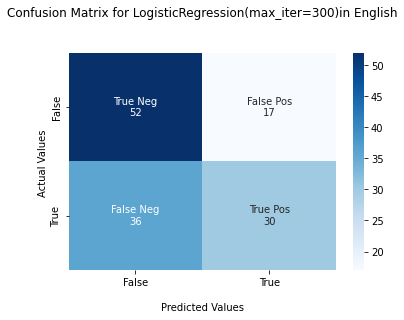

Model trained in English and using SGDClassifier(loss='modified_huber') model has 56.30% accuracy


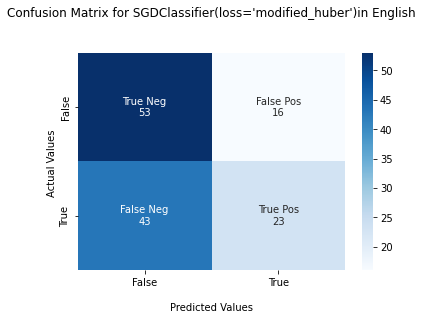

Model trained in English and using RandomForestClassifier() model has 57.04% accuracy


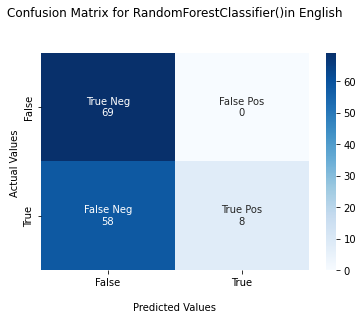

Model trained in English and using DecisionTreeClassifier() model has 56.30% accuracy


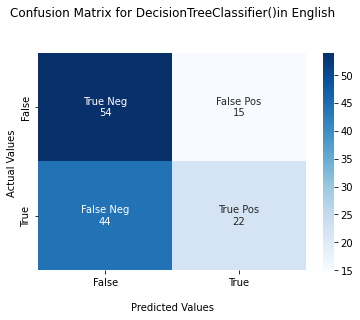

In [22]:
#Testing the English Translated version of Spanish Test Dataset
#Let's see... Does the English trained models perform better than the Spanish trained models? 
enSpnModelList = []
for model in models: 
    enSpnModel = makeModel(model, 'EnSpn')
    enSpnModelList.append(enSpnModel)

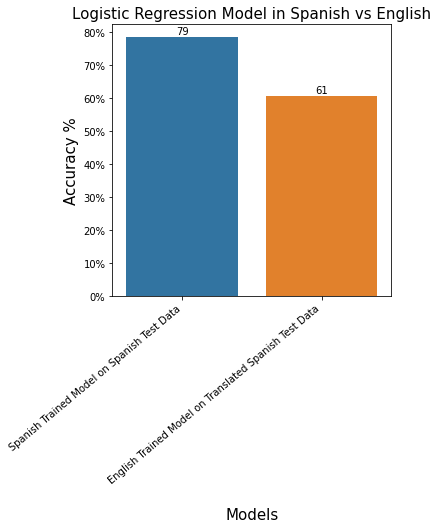

In [25]:
#Make chart to compare accuracies of spanish trained model vs english trained model on Spanish Test Data
spnLogModel = spnModelList[1]
enSpnLogModel = enSpnModelList[1]
logList = [spnLogModel, enSpnLogModel]

labelList =['Spanish Trained Model on Spanish Test Data', 'English Trained Model on Translated Spanish Test Data']
valList = []

for model in logList: 
    accuracy =model['accuracy']*100
    valList.append(accuracy)
        
dataDict = {'label' : labelList, 'value' : valList} 
plt.figure(figsize=(5,5))
ax = sns.barplot(x='label', y='value', data=dataDict)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Logistic Regression Model in Spanish vs English', fontsize = 15)
ax.set_xlabel('\nModels', fontsize = 15)
ax.set_ylabel('Accuracy %', fontsize = 15)
ax.yaxis.set_major_formatter(PercentFormatter())
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)

Model trained in Spanish and using GaussianNB() model has 53.89% accuracy


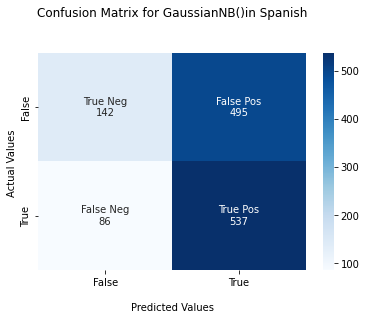

Model trained in Spanish and using LogisticRegression(max_iter=300) model has 68.17% accuracy


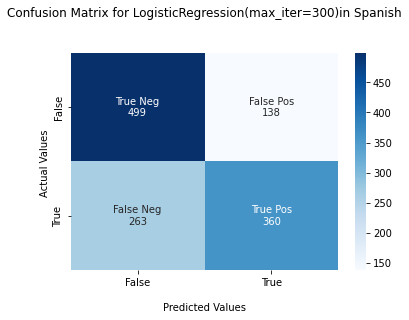

Model trained in Spanish and using SGDClassifier(loss='modified_huber') model has 65.48% accuracy


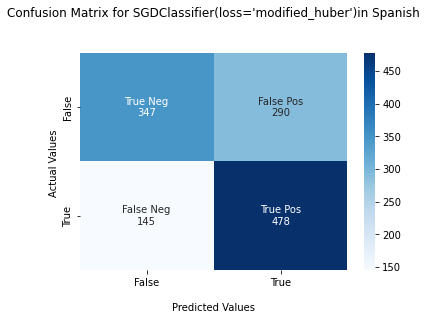

Model trained in Spanish and using RandomForestClassifier() model has 65.08% accuracy


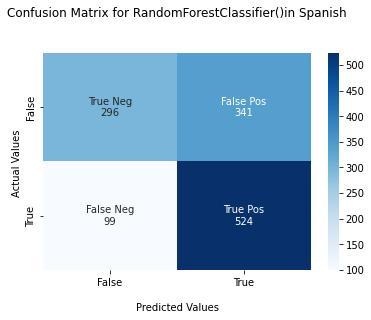

Model trained in Spanish and using DecisionTreeClassifier() model has 59.05% accuracy


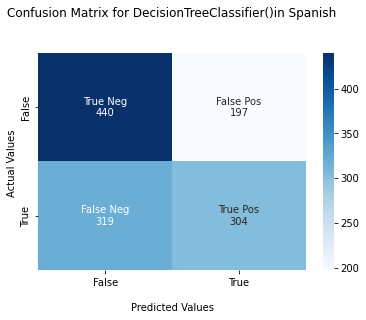

In [26]:
#Testing the Spanish Translated version of English Test Dataset
#Let's see... Does the Spanish trained models perform better than the English trained models? 
spnEnModelList = []
for model in models: 
    spnEnModel = makeModel(model, 'SpnEn')
    spnEnModelList.append(spnEnModel)

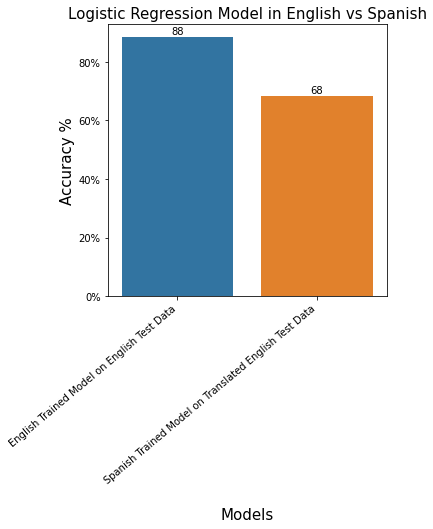

In [27]:
#Make chart to compare accuracies of english trained model vs spanish trained model on English Test Data
enLogModel = engModelList[1]
spnEnLogModel = spnEnModelList[1]
logList = [enLogModel, spnEnLogModel]

labelList =['English Trained Model on English Test Data', 'Spanish Trained Model on Translated English Test Data']
valList = []

for model in logList: 
    accuracy = model['accuracy']*100
    valList.append(accuracy)
        
dataDict = {'label' : labelList, 'value' : valList} 
plt.figure(figsize=(5,5))
ax = sns.barplot(x='label', y='value', data=dataDict)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Logistic Regression Model in English vs Spanish', fontsize = 15)
ax.set_xlabel('\nModels', fontsize = 15)
ax.set_ylabel('Accuracy %', fontsize = 15)
ax.yaxis.set_major_formatter(PercentFormatter())
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)